In [1]:
from AnoGan import Generator, Discriminator
from train import train_gan
from utils import GAN_Img_Dataset, make_datapath_list, make_test_datapath_list, Anomaly_score, weights_init

# data setting

In [2]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_img_list=make_datapath_list()

mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(train_img_list, mean, std)

batch_size = 64
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)  
imges = next(batch_iterator) 
print(imges.size()) # (batch_size, channel, width, height)

torch.Size([64, 1, 64, 64])


# train

In [4]:
G = Generator()
D = Discriminator()

weights_init(G)
weights_init(D)

In [5]:
num_epochs = 200
G_update, D_update = train_gan(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)

torch device : cuda:0
Epoch 10
D_Loss:0.0186, G_Loss:0.3533
Epoch 20
D_Loss:0.1173, G_Loss:0.1744
Epoch 30
D_Loss:0.0749, G_Loss:0.2080
Epoch 40
D_Loss:0.0960, G_Loss:0.1502
Epoch 50
D_Loss:0.0945, G_Loss:0.1764
Epoch 60
D_Loss:0.1245, G_Loss:0.1460
Epoch 70
D_Loss:0.0973, G_Loss:0.1960
Epoch 80
D_Loss:0.0568, G_Loss:0.2204
Epoch 90
D_Loss:0.0774, G_Loss:0.1912
Epoch 100
D_Loss:0.0751, G_Loss:0.2395
Epoch 110
D_Loss:0.0636, G_Loss:0.2334
Epoch 120
D_Loss:0.0406, G_Loss:0.3296
Epoch 130
D_Loss:0.0504, G_Loss:0.3451
Epoch 140
D_Loss:0.0633, G_Loss:0.3744
Epoch 150
D_Loss:0.0444, G_Loss:0.3187
Epoch 160
D_Loss:0.0480, G_Loss:0.3689
Epoch 170
D_Loss:0.0354, G_Loss:0.4271
Epoch 180
D_Loss:0.0377, G_Loss:0.5340
Epoch 190
D_Loss:0.0408, G_Loss:0.5089
Epoch 200
D_Loss:0.0145, G_Loss:0.5588


# test

In [6]:
test_img_list = make_test_datapath_list()

mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(test_img_list, mean, std)

batch_size = 5

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# 최적의 Z를 찾아보자
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
x = imges[0:5]
x = x.to(device)

z = torch.randn(5, 20).to(device)
z = z.view(z.size(0), z.size(1), 1, 1)

z.requires_grad = True
z_optimizer = optim.Adam([z], lr=1e-3)

for epoch in range(1, 5000+1):
    fake_img = G_update(z)
    loss, _, _ = Anomaly_score(x, fake_img, D_update, Lambda=0.1)

    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()

    if epoch % 1000 == 0:
        print(f'epoch {epoch} || loss_total : {float(loss):.4f}')

epoch 1000 || loss_total : 2593.1565
epoch 2000 || loss_total : 2225.9827
epoch 3000 || loss_total : 1993.1602
epoch 4000 || loss_total : 1883.7012
epoch 5000 || loss_total : 1850.4369


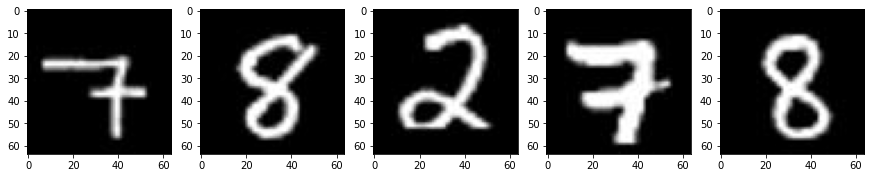

In [8]:
batch_iterator = iter(test_dataloader)
imges = next(batch_iterator)  

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

total loss： [188. 485. 182. 709. 285.]


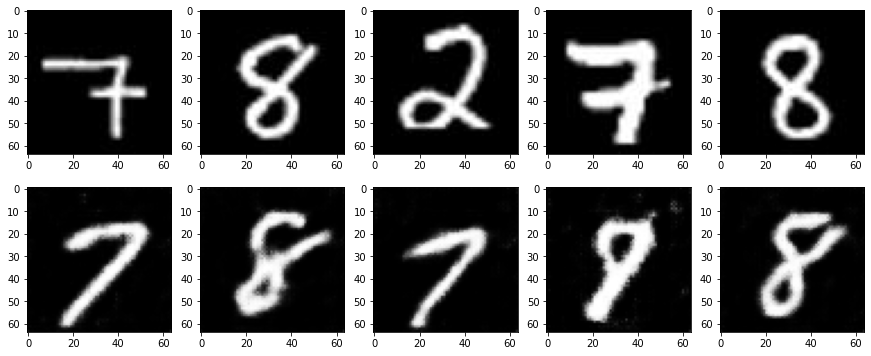

In [9]:
G_update.eval()
fake_img = G_update(z)

loss, loss_each, residual_loss_each = Anomaly_score(
    x, fake_img, D_update, Lambda=0.1)

loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):

    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_img[i][0].cpu().detach().numpy(), 'gray')